<a id='top'></a>

## Data Cleaning: 
#### Cleaning "[Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology](https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip)" (Moro et al., 2011)
##### Luke Barry


This project cleans and cleans and examines data for any outliers before exporting the tidied data to a csv file.

Further information on the columns can be found in the '[Bank Client Data](#ref)' cell.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# importing csv
df = pd.read_csv(r'C:\Users\LukeB\Documents\ELU\bank-full.csv', na_values='unknown')
df.head()

,"age;""job"";""marital"";""education"";""default"";""balance"";""housing"";""loan"";""contact"";""day"";""month"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""y"""
0,"58;""management"";""married"";""tertiary"";""no"";2143..."
1,"44;""technician"";""single"";""secondary"";""no"";29;""..."
2,"33;""entrepreneur"";""married"";""secondary"";""no"";2..."
3,"47;""blue-collar"";""married"";""unknown"";""no"";1506..."
4,"33;""unknown"";""single"";""unknown"";""no"";1;""no"";""n..."


In [3]:
# making a copy in case I mess up passed the point of no return
df2 = df.copy()

In [4]:
# creating a new dataframe 'bank'
df2.columns = df2.columns.str.replace('"', '')
col = df2.columns.str.split(';')
info = df2.iloc[:, 0].str.replace('"', '').str.split(';', expand=True)
col1 = col[0]
col1
bank = pd.DataFrame(info)
bank.columns = col1
bank = bank.rename(columns={'y': 'term_deposit'})
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
# updating 'unknown values to NaN'
bank = bank.replace('unknown', np.NaN)

In [6]:
# combining month and day to one column 'contact_date'
bank['contact_date'] = bank['month'].str.capitalize() + ' ' + bank['day']
bank['contact_date']

0         May 5
1         May 5
2         May 5
3         May 5
4         May 5
          ...  
45206    Nov 17
45207    Nov 17
45208    Nov 17
45209    Nov 17
45210    Nov 17
Name: contact_date, Length: 45211, dtype: object

In [7]:
#converting to datetime
bank['contact_date'] =  pd.to_datetime(bank['contact_date'], format='%b %d')
bank['contact_date']  = bank['contact_date'].dt.strftime('%b %d')
bank['contact_date']

0        May 05
1        May 05
2        May 05
3        May 05
4        May 05
          ...  
45206    Nov 17
45207    Nov 17
45208    Nov 17
45209    Nov 17
45210    Nov 17
Name: contact_date, Length: 45211, dtype: object

In [8]:
#getting rid of month and day columns
bank = bank.drop(['month','day'], axis=1)

In [9]:
#checking for null values
bank.isnull().sum().sort_values(ascending=False)

poutcome        36959
contact         13020
education        1857
job               288
contact_date        0
term_deposit        0
previous            0
pdays               0
campaign            0
duration            0
loan                0
housing             0
balance             0
default             0
marital             0
age                 0
dtype: int64

In [10]:
# checking what values are in the columns with na values
print('Unique Values: ')
print('poutcome: ', bank['poutcome'].unique())
print('contact: ', bank['contact'].unique())
print('education: ', bank['education'].unique())
print('job: ', bank['job'].unique())

Unique Values: 
poutcome:  [nan 'failure' 'other' 'success']
contact:  [nan 'cellular' 'telephone']
education:  ['tertiary' 'secondary' nan 'primary']
job:  ['management' 'technician' 'entrepreneur' 'blue-collar' nan 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']


'Other' and NaN in terms of success and failure are close enough to be merged.

In [11]:
# filling na with other
bank['poutcome'] = bank['poutcome'].fillna('other')
bank['poutcome'].isna().sum()

0

In [12]:
# inspecting contact
bank['contact'].value_counts()

cellular     29285
telephone     2906
Name: contact, dtype: int64

The difference between 'telephone' and 'cellular' is inconsiquential and holds no useful information. I will drop this column.

In [13]:
# dropping contact column
bank = bank.drop('contact', axis=1)

In [14]:
# inspecting education
print('NaN:        ', bank['education'].isna().sum())
print(bank['education'].value_counts())

NaN:         1857
secondary    23202
tertiary     13301
primary       6851
Name: education, dtype: int64


I think it is a fair assumption that a vast majority of respondants have finished secondary school, I will replace the reletively small amount of na values with secondary school.

In [15]:
# replacing NAN with mode
bank['education'] = bank['education'].fillna(bank['education'].mode()[0])
print('NaN:        ', bank['education'].isna().sum())
print(bank['education'].value_counts())

NaN:         0
secondary    25059
tertiary     13301
primary       6851
Name: education, dtype: int64


In [16]:
# inspecting job column
print(bank['job'].value_counts())

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Name: job, dtype: int64


According to [Europa.eu](https://ec.europa.eu/eurostat/documents/2995521/5033358/3-30112011-BP-EN.PDF/9f1b0596-97ca-4d82-a98d-7e636438e91c#:~:text=Between%20October%202010%20and%20October,to%209.9%25%20in%20the%20EU27.), the unemployment rate in Europe was around 9.8%. I will use this information to determine the likelihood of NaN results being unemployed.

In [17]:
# Adding nan and unemployed and comparing to europe's average
print('No response + unemployed:', ((bank['job'].isnull().sum() / bank.shape[0]) + (len(bank[bank['job'] == 'unemployed']) / bank.shape[0])) * 100)
print('Europe unemployment rate: 9.8')

No response + unemployed: 3.519055097210856
Europe unemployment rate: 9.8


Given the fact that the unemployed percentage is still significantly what was the average for europe at the time, I think it is reasonable to assume a large amount of NaN responses were unemployed. 

In [18]:
# changing Nan values to unemployed
bank['job'] = bank['job'].fillna('unemployed')
print('expected: ', 1303 + 288)
print('actual: ', len(bank[bank['job'] == 'unemployed']))

expected:  1591
actual:  1591


In [19]:
# check to ensure all NaN values have been accounted for
print(bank.isnull().sum().sort_values(ascending=False))

contact_date    0
term_deposit    0
poutcome        0
previous        0
pdays           0
campaign        0
duration        0
loan            0
housing         0
balance         0
default         0
education       0
marital         0
job             0
age             0
dtype: int64


When exploring the data, I wasn't able to find any outliers that would deem significant enough to change or remove. I did however, find that the balance was skewed to the right, with a max significantly higher than the mean, so I wanted to examine why that is.

In [20]:
# balance data shows that max is significantly higher than the mean and std
bank.balance = bank.balance.astype(float)
bank.balance.describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

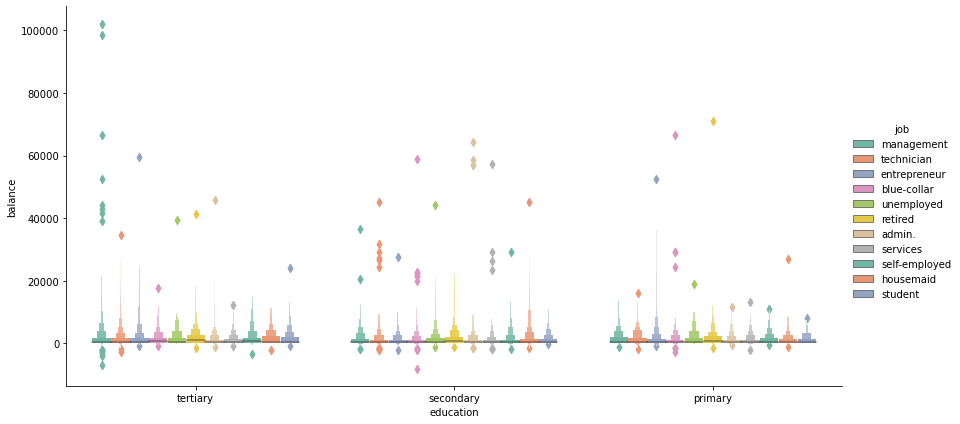

In [21]:
# comparing balance to education and occupation
sns.catplot(x='education', y='balance', hue='job', palette='Set2', kind='boxen', height=6, aspect=2, data=bank)
plt.show()

The data is easily explained by revealing the extremely high balances being attributed to individuals with tertiary education and in likely high level management roles. The balance column will, therefore, remain unchanged.

In [22]:
# preview resulting dataframe
bank.columns = bank.columns.str.capitalize().str.replace('_', ' ')
bank.head(10)

,Age,Job,Marital,Education,Default,Balance,Housing,Loan,Duration,Campaign,Pdays,Previous,Poutcome,Term deposit,Contact date
0,58,management,married,tertiary,no,2143.0,yes,no,261,1,-1,0,other,no,May 05
1,44,technician,single,secondary,no,29.0,yes,no,151,1,-1,0,other,no,May 05
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,76,1,-1,0,other,no,May 05
3,47,blue-collar,married,secondary,no,1506.0,yes,no,92,1,-1,0,other,no,May 05
4,33,unemployed,single,secondary,no,1.0,no,no,198,1,-1,0,other,no,May 05
5,35,management,married,tertiary,no,231.0,yes,no,139,1,-1,0,other,no,May 05
6,28,management,single,tertiary,no,447.0,yes,yes,217,1,-1,0,other,no,May 05
7,42,entrepreneur,divorced,tertiary,yes,2.0,yes,no,380,1,-1,0,other,no,May 05
8,58,retired,married,primary,no,121.0,yes,no,50,1,-1,0,other,no,May 05
9,43,technician,single,secondary,no,593.0,yes,no,55,1,-1,0,other,no,May 05


In [23]:
# exporting to csv
bank.to_csv('bank.csv', index=False, encoding='utf-8')

   <a id='ref'></a>
   
   ## Bank client data:
   Input variables:
   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
                                       
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   
   5 - default: has credit in default? (binary: "yes","no")
   
   6 - balance: average yearly balance, in euros (numeric) 
   
   7 - housing: has housing loan? (binary: "yes","no")
   
   8 - loan: has personal loan? (binary: "yes","no")
   
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
   
  10 - day: last contact day of the month (numeric)
  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  
  12 - duration: last contact duration, in seconds (numeric)
  
  other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")
  
  [Top](#top)